### Preprocess non-diseased nuclei adata

#### Koenig et al. 2022 (Lavine Lab)

1. Technology: 10x 5ʹ v1.1
2. Cell vs. nuclei: Nuclei
3. Region: LV (apical anterior wall)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Read in the Koenig dataset

In [3]:
%%time
# load entire dataset
adata = sc.read_h5ad("03_processed_all_Koenig.h5ad")
adata = adata[adata.obs.disease == "Healthy", :].copy()
adata.obs['age'] = adata.obs.age.astype(int)
adata = adata[adata.obs['cell_or_nuclei'] == "Nuclei", :].copy()

CPU times: user 5.32 s, sys: 24.7 s, total: 30 s
Wall time: 30 s


In [4]:
# check that these are the raw counts (the sum of all values in the sparse matrix should be an integer value)
adata.X.sum(axis = 1)

matrix([[1245],
        [1464],
        [1668],
        ...,
        [2899],
        [1635],
        [1937]])

In [5]:
# store the raw counts
adata.layers["counts"] = adata.X

In [6]:
# check that adata.var are the gene symbols 
adata.var_names

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'RP11-34P13.14', 'RP11-34P13.9', 'FO538757.3', 'FO538757.2',
       'AP006222.2',
       ...
       'AP001468.1', 'AP001469.1', 'AP001469.2', 'AP001469.3', 'AC136352.3',
       'AC136352.2', 'AC171558.3', 'BX004987.1', 'AC145212.1', 'MAFIP'],
      dtype='object', length=45068)

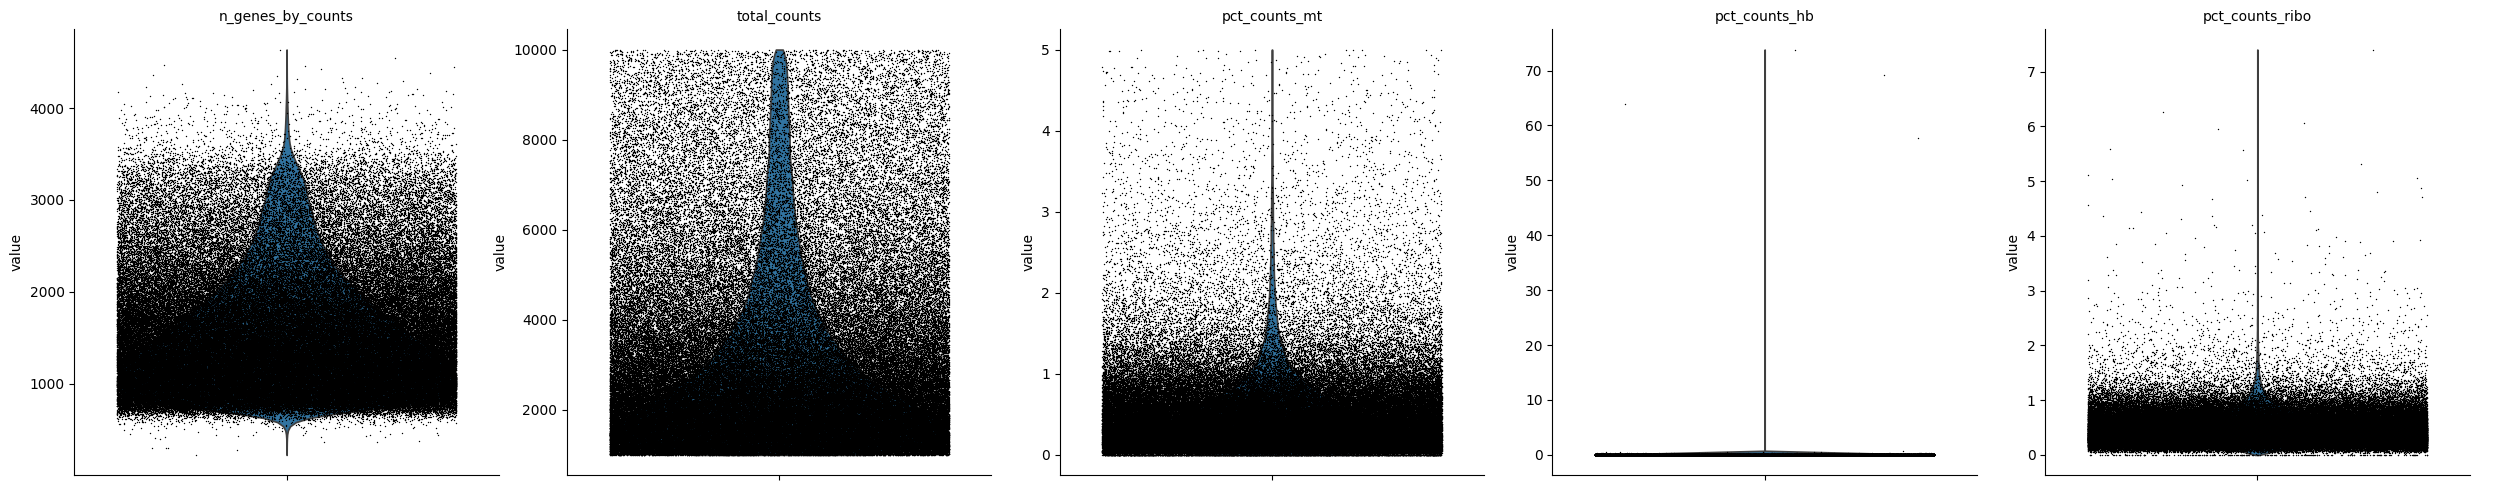

Filtered out 15 cells
CPU times: user 36 s, sys: 43.3 s, total: 1min 19s
Wall time: 17.6 s


In [7]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [8]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 240 likely doublets
CPU times: user 23min 52s, sys: 16min 52s, total: 40min 45s
Wall time: 13min 44s


2024-11-22 23:01:25,520 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-22 23:01:33,546 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-22 23:01:34,371 - harmonypy - INFO - Iteration 1 of 10
2024-11-22 23:02:47,847 - harmonypy - INFO - Iteration 2 of 10
2024-11-22 23:04:05,009 - harmonypy - INFO - Iteration 3 of 10
2024-11-22 23:05:20,660 - harmonypy - INFO - Converged after 3 iterations


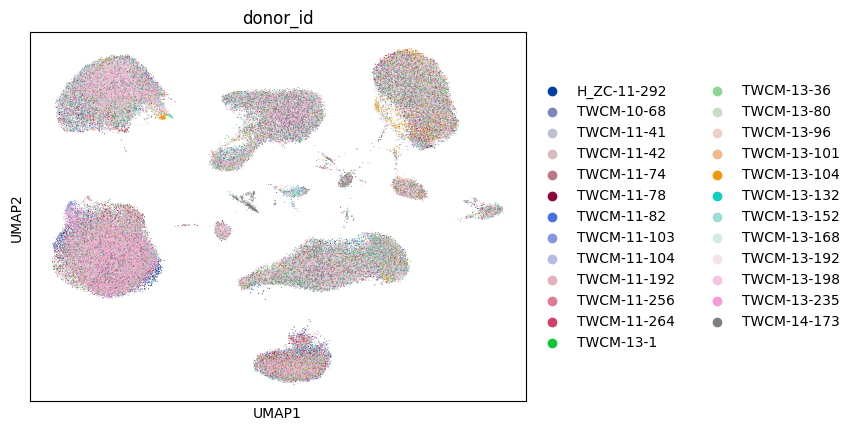

In [9]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

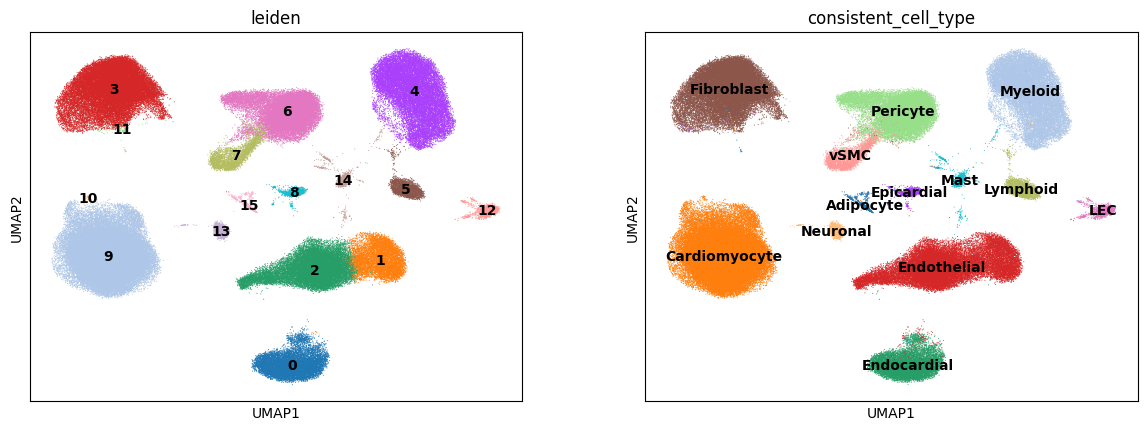

In [10]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [11]:
set(adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endocardial',
 'Endothelial',
 'Epicardial',
 'Fibroblast',
 'LEC',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'vSMC'}

In [12]:
adata.write("processed_Koenig_ND.h5ad")